<a href="https://colab.research.google.com/github/mr-popo123/PatternFlow/blob/master/GCN_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Author name: Arsh Upadhyaya
Roll no. s4753993
Code for 2 layer GCN
'''

'\nAuthor name: Arsh Upadhyaya\nRoll no. s4753993\nCode for 2 layer GCN\n'

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import math
import torch.nn.init as init
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.optim as optim
from random import sample
import matplotlib.pyplot as plt

In [5]:
def load_data(file_path):
    
    data = np.load("/content/drive/MyDrive/facebook.npz")#path of file through google drive
    edges = data['edges']
    features = data['features']
    labels = data['target']

    features = sp.csr_matrix(features)

    adj= sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),shape=(labels.shape[0], labels.shape[0]))

    #normalize
    colsum = np.array(adj.sum(0))
    D = np.power(colsum, -1)[0]
    D[np.isinf(D)] = 0
    D_inv = sp.diags(D)
    adj_trans = D_inv.dot(adj)

    #transform data type
    indices = torch.LongTensor(np.vstack((adj_trans.tocoo().row, adj_trans.tocoo().col)))
    values = torch.FloatTensor(adj_trans.data)
    shape = adj_trans.shape

    adj_trans = torch.sparse_coo_tensor(indices, values, shape)
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(labels)

    return adj_trans, features, labels

In [6]:



class GraphConvolution(Module):
    '''
    Starting of graph convolutional layer.
    Parameters:
    input_features: dimensions of input layer
    output_features: dimenstions of output layer
    use_bias: optional but good practice
    '''

    def __init__(self, in_features, out_features, use_bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias=use_bias
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if self.use_bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
     #initialize parameters 
    def reset_parameters(self):
        self.weight = nn.init.kaiming_uniform_(self.weight)
        if self.use_bias:
            init.zeros_(self.bias)

# parameters:
# in_feature: an n-dimenstional vector
# adj_matrix: an adjacency matrix in tensor format

    def forward(self, input, adj):

       support = torch.mm(input, self.weight) 
       output = torch.sparse.mm(adj, support)

       return output


class GCN(nn.Module):

#  A model that contains 2 layers of GCN , by creating 2 instances from GraphConvolution function
#  parameters:
#  in_feature:n dimensional vector, which is input
#  out_class: n dimensional vector, final output
#  in this case model goes 128->32->4
#  since in_feature=128(known from dataset)
#  out_class=4(since finally 4 classes)

  def __init__(self, in_feature,  out_class, dropout):
        super(GCN, self).__init__()

        self.gcn_conv_1 = GraphConvolution(in_feature, 32)#32 is like the hidden layer for the overall model
        self.gcn_conv_2 = GraphConvolution(32, out_class)
        self.dropout = dropout

  def forward(self, x, adj):
        x = F.relu(self.gcn_conv_1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gcn_conv_2(x, adj)

        return F.log_softmax(x, dim=1)

In [7]:
def accuracy(output, labels):
    '''
    calculate accuracy
    parameters: 
    output:result of running an instance of the model
    labels: the true value
    function compares ratio of two values, giving result<1, 
    as predicted probability always less than true value
    '''
    predict = output.argmax(1)
    acc_ = torch.div(predict.eq(labels).sum(), labels.shape[0])
    return acc_

In [8]:
def loss(output,labels):

    prab = output.gather(1, labels.view(-1,1))
    loss = -torch.mean(prab)
    return loss

In [9]:
def train_model(n_epochs):
  '''
  parameter: number of epochs
  trains model over the range of the epoch and at each train, 
  calculates accuracy and losses
  '''
  train_losses=[]
  validation_losses=[]
  train_accuracies=[]
  validation_accuracies=[]
  for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output=model(features,adj)
    train_loss=loss(output[train_set],labels[train_set])
    train_losses.append(train_loss.item())

    train_accuracy=accuracy(output[train_set],labels[train_set])
    train_accuracies.append(train_accuracy.item())
    train_loss.backward()
    optimizer.step()
    output=model(features,adj)
    validation_loss=loss(output[val_set],labels[val_set])
    validation_losses.append(validation_loss.item())
    validation_accuracy=accuracy(output[val_set],labels[val_set])
    validation_accuracies.append(validation_accuracy.item())
    print('Epoch: {:04d}'.format(epoch + 1),
              'Train loss: {:.4f}'.format(train_loss.item()),
              'Train accuracy: {:.4f}'.format(train_accuracy.item()),
              'Validation loss: {:.4f}'.format(validation_loss.item()),
              'Validation accuracy: {:.4f}'.format(validation_accuracy.item()))
    
    np.save('train_losses', train_losses)
    np.save('train_accuracies', train_accuracies)
    np.save('validation_losses', validation_losses)
    np.save('validation_accuracies', validation_accuracies)


In [10]:
def test_model():
  output=model(features,adj)
  test_loss=loss(output[test_set],labels[test_set])
  test_accuracy=accuracy(output[test_set],labels[test_set])
  print('Test set results:',
        'Test loss: {:.4f}'.format(test_loss.item()),
        'Test accuracy: {:.4f}'.format(test_accuracy.item()))

Epoch: 0001 Train loss: 4.3900 Train accuracy: 0.3240 Validation loss: 3.4887 Validation accuracy: 0.3954
Epoch: 0002 Train loss: 3.5393 Train accuracy: 0.3576 Validation loss: 2.6608 Validation accuracy: 0.4551
Epoch: 0003 Train loss: 2.8554 Train accuracy: 0.4306 Validation loss: 2.1850 Validation accuracy: 0.5011
Epoch: 0004 Train loss: 2.2749 Train accuracy: 0.5056 Validation loss: 1.8538 Validation accuracy: 0.5565
Epoch: 0005 Train loss: 1.9135 Train accuracy: 0.5525 Validation loss: 1.5360 Validation accuracy: 0.6153
Epoch: 0006 Train loss: 1.6013 Train accuracy: 0.6061 Validation loss: 1.3416 Validation accuracy: 0.6513
Epoch: 0007 Train loss: 1.4299 Train accuracy: 0.6413 Validation loss: 1.2913 Validation accuracy: 0.6609
Epoch: 0008 Train loss: 1.1754 Train accuracy: 0.6905 Validation loss: 1.0890 Validation accuracy: 0.7132
Epoch: 0009 Train loss: 1.1588 Train accuracy: 0.6994 Validation loss: 0.9336 Validation accuracy: 0.7425
Epoch: 0010 Train loss: 0.9862 Train accuracy:

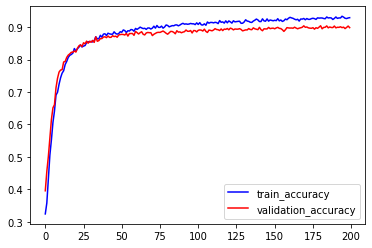

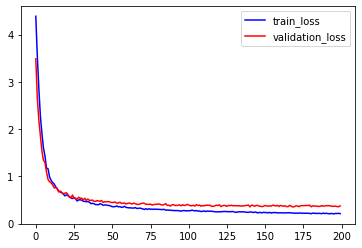

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


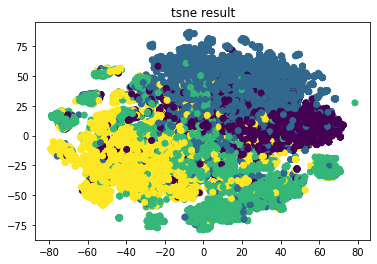

In [36]:
    adj, features, labels = load_data('facebook.npz')#returns normalized adjacency matrix, tensor features and labels
    features.shape[0]
    num_nodes=features.shape[0]
    #split data in semi supervised quatity, i.e train:set:test=20:20:60(since n_train<n_test)
    train_set = torch.LongTensor(range(int(num_nodes*0.2)))
    val_set = torch.LongTensor(range(int(num_nodes*0.2),int(num_nodes*0.4)))
    test_set = torch.LongTensor(range(int(num_nodes*0.4),num_nodes))

    model = GCN(in_feature=features.shape[1],
                out_class=len(np.unique(labels)), dropout=0.5)

    optimizer = optim.Adam([model.gcn_conv_1.weight,model.gcn_conv_2.weight], lr=0.01)
    train_model(200)
    test_model()
    train_accuracies = np.load('train_accuracies.npy')
    train_losses = np.load('train_losses.npy')
    validation_accuracies = np.load('validation_accuracies.npy')
    validation_losses = np.load('validation_losses.npy')
    plt.plot(range(200),train_accuracies,'b')
    plt.plot(range(200),validation_accuracies,'r')
    plt.legend(['train_accuracy', 'validation_accuracy'])
    plt.show()
    plt.plot(range(200),train_losses,'b')
    plt.plot(range(200),validation_losses,'r')
    plt.legend(['train_loss', 'validation_loss'])
    plt.show()
    outputs = model.gcn_conv_1(features, adj).detach().numpy()
    plot_tsne(labels, outputs )
   

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def plot_tsne(labels,output):
  tsne=TSNE().fit_transform(outputs)
  plt.title('tsne result')
  plt.scatter(tsne[:,0],tsne[:,1],marker='o',c=labels)
  plt.savefig("GCS_tsne.png")